In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image

import os
import random
from imutils import paths
from collections import defaultdict 
import numpy as np
import time
import argparse

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

### The Resnet_18 Model

In [2]:
class resnet18_model(nn.Module):
    def __init__(self,
                 input_size: tuple = (224, 224, 3),
                 hidden_size: int = 64,
                 dropout: float = 0.5,
                 num_classes: int = 3,
                 **kwargs
                ):
        """
        Initialize a new network
        
        Inputs: 
        - input_size: Tuple, size of input data
        - hidden_size: Integer, number of units to use in hidden layer
        - dropout: Float, dropout coefficient
        - num_classes: Integer, number of classes
        """
        
        super(resnet18_model, self).__init__()
        
        # Use GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # load the resnet18 network
        self.model = models.resnet18(pretrained=True).to(device)
        self.model = nn.Sequential(*list(self.model.children())[:-1])

        # freeze weights of base model except last couple layers
        last_frozen = 56
        count = 0
        for param in self.model.parameters():
            count += 1
            if count < last_frozen:
                param.requires_grad = False
            
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

### The Pocovid Dataset Class

In [3]:
class PocovidDataset(Dataset):
    """Subclass of Dataset for POCOVID-Net data"""
  
    def __init__(self, data_path_info, transform=None):
        """
        Args:
          data_path_info (dict): Dictionary containing the paths and labels for images
          transform (callable, optional): Optional transform to be applied
              on a sample.
        """
        self.__transform = transform
        
        self.__covid_class = 0
        self.__pneu_class = 1
        self.__regular_class = 2

        covid_items = []
        pneu_items = []
        regular_items = []

        for i in range(len(data_path_info['path_list'])):
            if(data_path_info['label_list'][i] == 'covid'):
                covid_items.append(data_path_info['path_list'][i])
            elif(data_path_info['label_list'][i] == 'pneumonia'):
                pneu_items.append(data_path_info['path_list'][i])
            else:
                regular_items.append(data_path_info['path_list'][i])

        num_covid = 0
        num_pneu = 0
        num_regular = 0 
        
        self.__img_info = []
        for covid_filename in covid_items: 
            image = Image.open(covid_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((covid_filename,self.__covid_class))
                num_covid += 1
            
        for pneu_filename in pneu_items:
            image = Image.open(pneu_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((pneu_filename,self.__pneu_class))
                num_pneu += 1
                
        for regular_filename in regular_items:
            image = Image.open(regular_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((regular_filename,self.__regular_class)) 
                num_regular += 1

        self.__transform = transform
        self.__num_images = num_covid + num_pneu + num_regular
  
    def __len__(self):
        return self.__num_images
  
    def __getitem__(self,idx):
        img_name, img_class = self.__img_info[idx]
        image = Image.open(img_name)
        sample = [image, img_class]

        if self.__transform:
            sample = [self.__transform(image), img_class]

        return sample
    
    def get_covid_class_idx(self):
        return self.__covid_class
    
    def get_pneu_class_idx(self):
        return self.__pneu_class
    
    def get_regular_class_idx(self):
        return self.__regular_class
    
    def get_class_map(self):
        class_map = {self.get_covid_class_idx() : 'covid',
            self.get_pneu_class_idx() : 'pneumonia',
            self.get_regular_class_idx() : 'regular'}
        return class_map

### The Training Class

In [4]:
CROSS_VAL_DIR = '../data/cross_validation'
MODEL_SAVE_DIR = '../trained_models'
N_EPOCHS = 1
FOLD = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 1e-4
BATCH_SIZE = 16
IMG_WIDTH, IMG_HEIGHT = 224, 224
MODEL_NAME = 'resnet18'

In [5]:
# ### The Trainer Class
class Trainer():
    
    def __init__(self, model_name=MODEL_NAME, lr=LR, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, 
                 image_width=IMG_WIDTH, image_height=IMG_HEIGHT, cross_val_dir=CROSS_VAL_DIR,
                model_save_dir=MODEL_SAVE_DIR, fold=FOLD):
        
        if(model_name=='vgg16'):
            self.model = VGG16_model().to(device)
        elif(model_name=='resnet18'):
            self.model = resnet18_model().to(device)
        else:
            print('Select models from the following:\n 1) vgg16\n 2) resnet18')
                    
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.fold = fold
        self.cross_val_dir = cross_val_dir
        
        self.image_width = image_width
        self.image_height = image_height
        
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(params = self.model.parameters(), lr=self.lr) #experiment with weigth_decay
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.95) # use scheduler
        
        self.model_save_dir = model_save_dir
        self.model_name = model_name
        
        self.train_loader = None
        self.test_loader = None
        
        self.classes = None
        self.class_map = None
        
        
    def get_train_test_info(self):
        """
        Get information dictionaries for train and test data
        """
    
        imagePaths = list(paths.list_images(self.cross_val_dir))

        train_path_info = defaultdict(list)
        test_path_info = defaultdict(list)

        for imagePath in imagePaths:
            path_parts = imagePath.split(os.path.sep)
            fold_number = path_parts[-3][-1]
            label = path_parts[-2]
            if(fold_number==str(self.fold)):
                test_path_info['path_list'].append(imagePath)
                test_path_info['label_list'].append(label)
            else:
                train_path_info['path_list'].append(imagePath)
                train_path_info['label_list'].append(label)

        return train_path_info, test_path_info
    
    
    def get_train_test_loaders(self, num_workers=2):
        
        """
        Get the train and test data according to the fold
        """
        
        train_path_info, test_path_info = self.get_train_test_info()

        train_transform = transforms.Compose([transforms.Resize((self.image_width, self.image_height)),
                                           transforms.RandomAffine(10,translate=(0.1,0.1)),
                                           transforms.ToTensor()])

        test_transform = transforms.Compose([transforms.Resize((self.image_width, self.image_height)),
                                           transforms.ToTensor()])

        trainset = PocovidDataset(train_path_info, transform = train_transform)
        testset = PocovidDataset(test_path_info, transform = test_transform)
        
        self.class_map = trainset.get_class_map()
        self.classes = [self.class_map[key] for key in sorted(self.class_map)]

        train_loader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, shuffle=True,
                                          batch_size=self.batch_size, drop_last=True)

        test_loader = torch.utils.data.DataLoader(testset, num_workers=num_workers, shuffle=True,
                                        batch_size=self.batch_size)
        
        return train_loader, test_loader
    
    def train(self, iterator):
        """
        The train function
        """
    
        self.model.train()

        epoch_loss = 0

        for i, batch in enumerate(iterator):

            inputs, labels = batch[0].to(device), batch[1].to(device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)

            loss = self.criterion(outputs, labels)

            loss.backward()

            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(iterator)

    def evaluate(self, iterator):
        """
        The eval function
        """
    
        self.model.eval()

        epoch_loss = 0

        with torch.no_grad():    
            for i, batch in enumerate(iterator):    

                inputs, labels = batch[0].to(device), batch[1].to(device)

                outputs = self.model(inputs)

                loss = self.criterion(outputs, labels)

                epoch_loss += loss.item()

        return epoch_loss / len(iterator)
    
    def epoch_time(self, start_time, end_time):
        """
        The utility function to measure the time taken by an epoch to run
        """
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    def training(self):
        """
        The training function which does the training by calling train and eval functions
        """
    
        best_valid_loss = np.inf
        c = 0
        
        self.train_loader, self.test_loader = self.get_train_test_loaders()
        
        # Create the model save dir if it already doesn't exist
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)
        
        for epoch in range(self.n_epochs):

            print(f'Epoch: {epoch+1:02}')

            start_time = time.time()

            train_loss = self.train(self.train_loader)
            valid_loss = self.evaluate(self.test_loader)

            epoch_mins, epoch_secs = self.epoch_time(start_time, time.time())

            c+=1
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(self.model.state_dict(), os.path.join(self.model_save_dir, '{}_trained.pt'.format(self.model_name)))
                c=0

            if c>4:
                #decrease lr if loss does not decrease after 5 steps
                self.scheduler.step()
                c=0

            print(f'Time: {epoch_mins}m {epoch_secs}s') 
            print(f'Train Loss: {train_loss:.3f}')
            print(f'Val   Loss: {valid_loss:.3f}')
            print('-'*100)
        print(best_valid_loss)
        
    def evaluate_model(self, iterator=None, proba=False, one_batch=False):
        
        if iterator is None:
            iterator = self.test_loader
    
        self.model.eval()

        images = []
        true_labels = []
        pred_labels = []
        pred_probs = []

        with torch.no_grad():    
            for i, batch in enumerate(iterator):    

                inputs, labels = batch[0].to(device), batch[1].to(device)

                outputs = self.model(inputs)

                y_prob = F.softmax(outputs, dim = -1)

                top_preds = y_prob.argmax(1, keepdim = True)

                images.append(inputs.to(device))
                true_labels.append(labels.to(device))
                pred_labels.append(top_preds.to(device))
                pred_probs.append(y_prob.to(device))

                if(one_batch):
                    break

        images = torch.cat(images, dim=0)
        true_labels = torch.cat(true_labels, dim=0)
        pred_labels = torch.cat(pred_labels, dim=0)
        pred_probs = torch.cat(pred_probs, dim=0)

        if(proba):
            return images, true_labels, pred_labels, pred_probs

        return images, true_labels, pred_labels
    
    def visualize_test_samples(self):
    
        images, true_labels, pred_labels, pred_probs = self.evaluate_model(proba=True, one_batch=True)

        true_labels = true_labels.cpu().numpy()
        pred_labels = pred_labels.cpu().numpy()
        pred_probs = pred_probs.cpu().numpy()


        rows = int(np.sqrt(len(images)))
        cols = int(np.sqrt(len(images)))

        fig = plt.figure(figsize = (25, 20))

        for i in range(rows*cols):

            ax = fig.add_subplot(rows, cols, i+1)

            image, true_label, pred_label, pred_prob = images[i], true_labels[i], pred_labels[i], pred_probs[i]
            image = image.permute(1, 2, 0)
            ax.imshow(image.cpu().numpy())
            ax.set_title(f'true label: {self.class_map[true_label]}\n' \
                        f'pred label: {self.class_map[pred_label[0]]} (Prob: {max(pred_prob):.3f})',
                        color = ('green' if true_label==pred_label[0] else 'red'))
            ax.axis('off')

        fig.subplots_adjust(hspace = 0.4)

        plt.show()
        
    def start_training(self):
        """
        To start training, evaluate the trained model and print the metrics
        """
        self.training()
        
        images, true_labels, pred_labels, pred_probs = self.evaluate_model(proba=True)
        
        metrics = Metrics(images, true_labels, pred_labels, pred_probs, self.classes)

        cm = metrics.get_confusion_matrix()
        print('The confusion matrix is:\n', cm)
        
        cr = metrics.get_classification_report()
        print('The classification report is:\n', cr)
        
        print('ROC Curves:')
        metrics.get_roc_curves()

### The Trained Model Class

In [6]:
class TrainedModel():
    
    def __init__(self, model_name='vgg16'):
        """
        To get the details of the pre-trained model
        """
        trainer = Trainer(model_name=model_name)
        self.model = trainer.model
        self.model_save_dir = trainer.model_save_dir
        self.model_name = model_name
        
    def loadModel(self):
        """
        To load the pre trained model
        """
        self.model.load_state_dict(torch.load(os.path.join(self.model_save_dir, '{}_trained.pt'.format(self.model_name)), map_location=torch.device(device)))
        return self.model
    
    def countParameters(self):
        """
        To get the number of trainable parameters of the model
        """
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    def printModel(self):
        """
        To print the network architecture
        """
        print(self.model)

### The Metrics Class

In [15]:
class Metrics():
    
    def __init__(self, images, true_labels, pred_labels, pred_probs, classes):

        self.images = images
        self.true_labels = true_labels
        self.pred_labels = pred_labels
        self.pred_probs = pred_probs
        self.classes = classes
        
    def plot_confusion_matrix(self):
        fig = plt.figure(figsize = (10, 10));
        ax = fig.add_subplot(1, 1, 1);
        cm = self.get_confusion_matrix()
        cm = ConfusionMatrixDisplay(cm, display_labels = self.classes);
        cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
        plt.xticks(rotation = 20)
    
    def get_confusion_matrix(self):
        cm = confusion_matrix(self.true_labels.cpu().numpy(), self.pred_labels.cpu().numpy())
        return cm
        
    def get_classification_report(self):
        cr = classification_report(self.true_labels.cpu().numpy(), self.pred_labels.cpu().numpy(), target_names=self.classes)
        return cr
      
    def get_roc_curves(self):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y = label_binarize(self.true_labels.cpu().numpy(), classes=[0, 1, 2])
        for i in range(len(self.classes)):
            fpr[i], tpr[i], _ = roc_curve(y[:, i], self.pred_probs.cpu().numpy()[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), self.pred_probs.cpu().numpy().ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(self.classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(self.classes)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= len(self.classes)

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                     ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                     ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        
        for i, color in zip(range(len(self.classes)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.show()

### Fixing Random Seeds

In [16]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Initializing parameters

In [17]:
CROSS_VAL_DIR = '../data/cross_validation'
MODEL_SAVE_DIR = '../trained_models'
N_EPOCHS = 1
FOLD = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 1e-4
BATCH_SIZE = 16
IMG_WIDTH, IMG_HEIGHT = 224, 224
MODEL_NAME = 'resnet18'

Epoch: 01
Time: 0m 17s
Train Loss: 0.450
Val   Loss: 0.922
----------------------------------------------------------------------------------------------------
0.9224485878063284
The confusion matrix is:
 [[272   2  25]
 [ 90 114  30]
 [146   4  52]]
The classification report is:
               precision    recall  f1-score   support

       covid       0.54      0.91      0.67       299
   pneumonia       0.95      0.49      0.64       234
     regular       0.49      0.26      0.34       202

    accuracy                           0.60       735
   macro avg       0.66      0.55      0.55       735
weighted avg       0.65      0.60      0.57       735

ROC Curves:


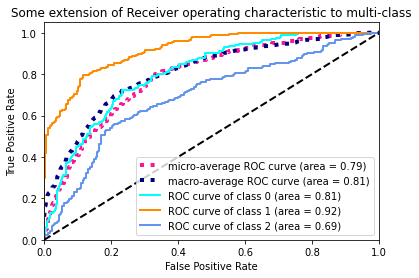

In [18]:
# Start the training
trainer = Trainer()
trainer.start_training()

In [ ]:
# Todo:
# 1) Implement ROC graph with confidence values (J)
# 2) Hypertune the paramaters for best results (N)
# 3) Implement voting classifier from all 5 folds using 5 models (A)
# 4) Add code for early stopping (A)
# 5) Do visualization stuff (N)
# 6) Refactor all code and make the training and testing scripts with args (A) --> Done
# 7) Finalize this notebook with all code included (A) --> 90% Done
# 8) Implement the flask api (A)
# 9) Test the script and prepare a notebook for Resnet model (J)